In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from dataloader.ts_reader import MultiModalDataset,VitalSignsDataset,vital_pre_train
from model.rnn_baseline import *
from model.autoencoder_v1_loss_train import *
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import torch.optim as optim
import torch
torch.cuda.empty_cache()


In [2]:

vital_signs_train = '/home/mei/nas/docker/thesis/data/hdf/train/ts_each_patient.h5'
vital_signs_val = '/home/mei/nas/docker/thesis/data/hdf/val/ts_each_patient.h5'
vital_signs_test = '/home/mei/nas/docker/thesis/data/hdf/test/ts_each_patient.h5'

train_dataset = VitalSignsDataset(vital_signs_train)
val_dataset = VitalSignsDataset(vital_signs_val)
test_dataset = VitalSignsDataset(vital_signs_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=vital_pre_train)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=vital_pre_train) 
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=vital_pre_train)

In [3]:
from torch.utils.data import DataLoader, TensorDataset

small_data_iter = iter(train_loader) 
inputs, lengths = next(small_data_iter)   

small_dataset = TensorDataset(inputs, lengths)
small_train_loader = DataLoader(small_dataset, batch_size=len(inputs), shuffle=True) 

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_features = 154  
embedding_dim = 128
model =BaselineRNN(n_features, embedding_dim,grid_size=(12,12)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)

In [6]:
stage1 = '/home/mei/nas/docker/thesis/data/model_results/rnn_baseline/stage1'
model1, pretrain_history = pretrain_encoder_decoder(
    model, train_loader, device, optimizer, start=1, epochs=100, save_dir=stage1, patience=20
)

[Pretrain] Epoch 10/100, Loss=5.2907, saved checkpoint.
[Pretrain] Epoch 20/100, Loss=4.4779, saved checkpoint.
[Pretrain] Epoch 30/100, Loss=4.4768, saved checkpoint.
[Pretrain] Epoch 40/100, Loss=4.1164, saved checkpoint.
[Pretrain] Epoch 50/100, Loss=4.1034, saved checkpoint.
[Pretrain] Epoch 60/100, Loss=3.9502, saved checkpoint.
[Pretrain] Epoch 70/100, Loss=3.7910, saved checkpoint.
[Pretrain] Epoch 80/100, Loss=3.8079, saved checkpoint.
[Pretrain] Epoch 90/100, Loss=3.8035, saved checkpoint.
[Pretrain] Epoch 100/100, Loss=3.6289, saved checkpoint.


In [7]:
model.use_som = True
lambda_cfg = {
    'kl': 1.0,
    'diversity': 0.05,
    'smooth': 0.03,
    'neighbor': 0.02,
    'l2': 1e-4
}
stage2 = '/home/mei/nas/docker/thesis/data/model_results/rnn_baseline/stage2'
optimizer = optim.Adam(model1.parameters(), lr=1e-3)
model2, joint_history = train_joint(
    model1, train_loader, val_loader, device, optimizer, start=1, epochs=100,
    save_dir=stage2, lambda_cfg=lambda_cfg, patience=40
)

[Joint] Epoch 10/100, Train=3.8954, Val=4.0447
[Joint] Epoch 20/100, Train=3.5839, Val=3.7934
[Joint] Epoch 30/100, Train=3.3260, Val=3.5695
[Joint] Epoch 40/100, Train=3.3028, Val=3.5170
[Joint] Epoch 50/100, Train=3.2056, Val=3.4541
[Joint] Epoch 60/100, Train=3.2762, Val=3.4399
[Joint] Epoch 70/100, Train=3.2299, Val=3.3710
[Joint] Epoch 80/100, Train=3.2530, Val=3.3743
[Joint] Epoch 90/100, Train=3.3515, Val=3.4290
[Joint] Epoch 100/100, Train=3.2385, Val=3.3209


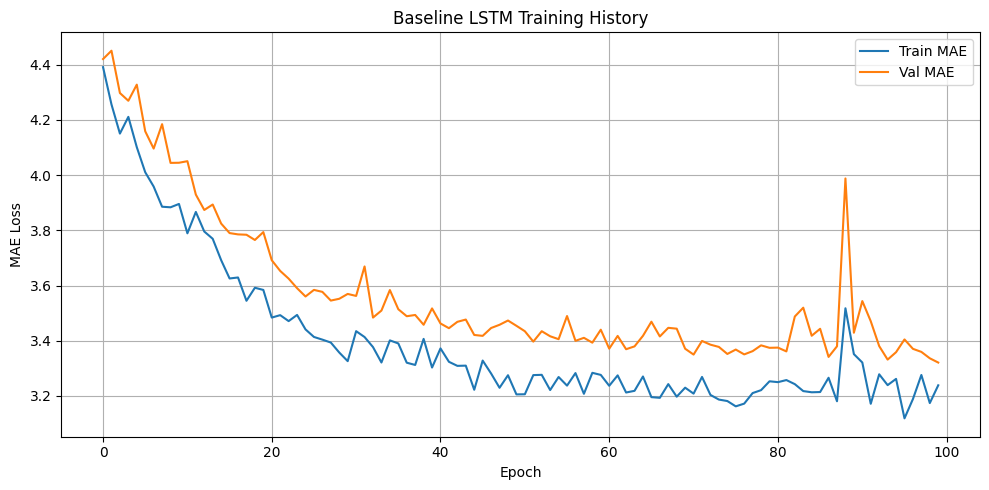

In [8]:
plot_baseline_history(joint_history)

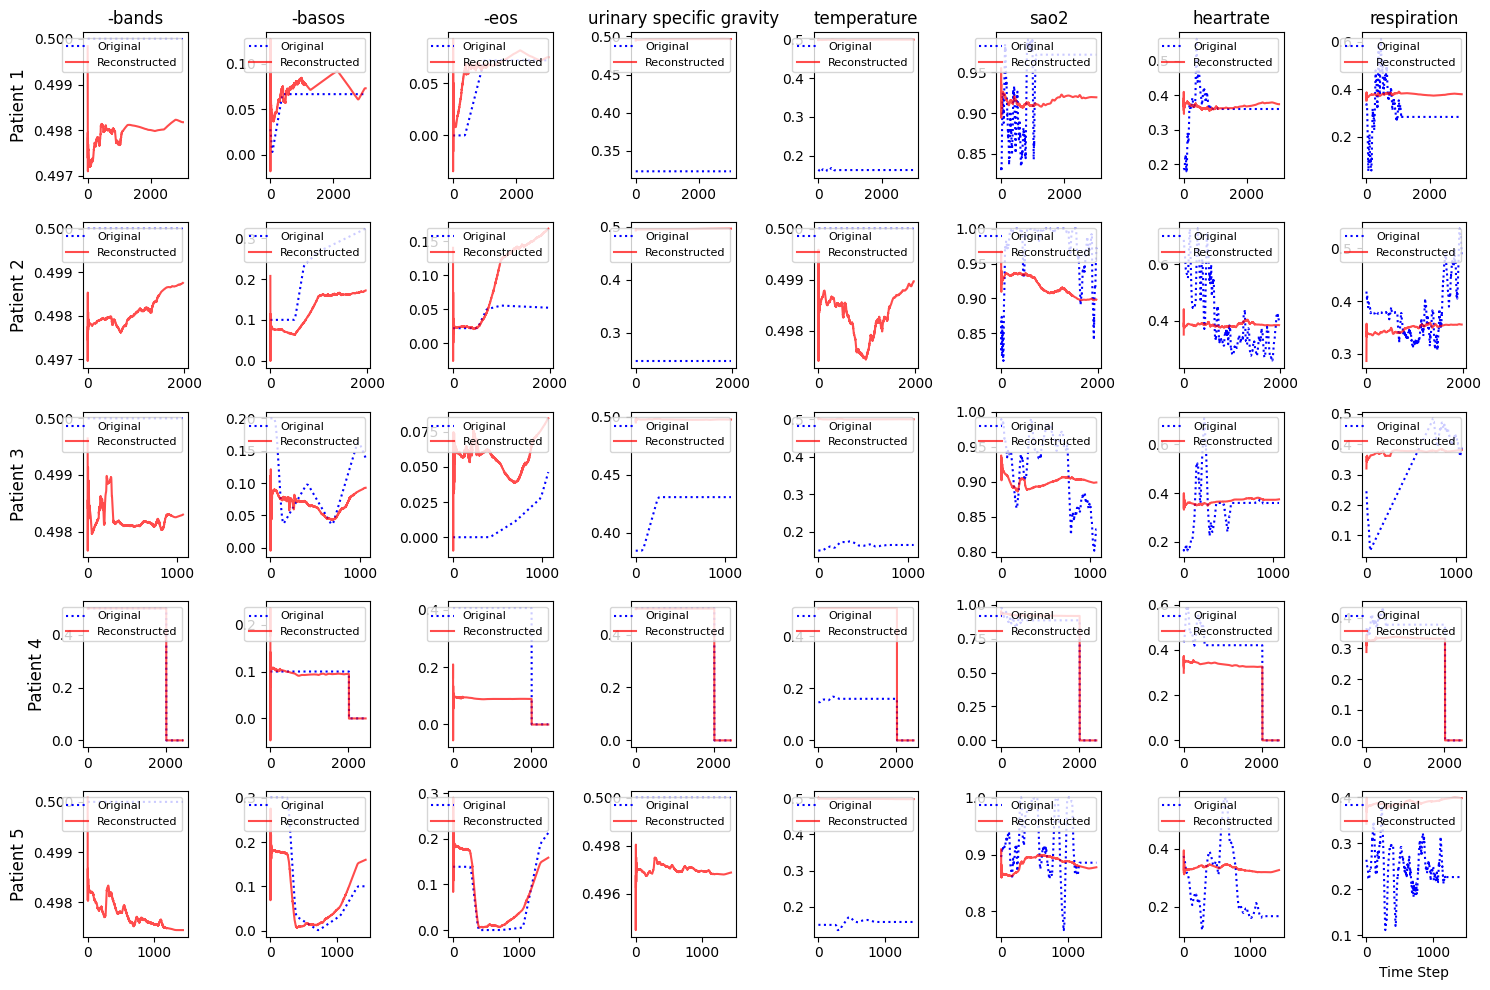

In [9]:
with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
    features = [line.strip() for line in f]

selected_feature_indices = [0,1,2,142,143,144,145,146]  #

visualize_recons(model2, test_loader, num_patients=5, feature_indices=selected_feature_indices, feature_names=features,device=device)